! pip install --user joblib scikit-learn==0.20.4

In [3]:
import numpy as np
import scipy as sp
from scipy import stats
import uproot
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
from scipy.special import erf

from tqdm import tqdm
from multiprocessing import Process, Manager, Value
matplotlib.rcParams.update({'font.size': 18})
import h5py, os, sys, glob, datetime, time
import subprocess

sys.path.append('../lib')
import time
from glob import glob
from decimal import Decimal

from histo_utilities import create_TH2D, create_TH1D, create_Canvas, make_effiency_plot, rootTH1_to_np
from progressBar import ProgressBar

from cebefo_style import cebefo_style
cebefo_style()

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import joblib
import pickle
from prettytable import PrettyTable

import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError

from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, Lambda
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model

Welcome to JupyROOT 6.12/07


/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-root_numpy/4.7.3-gnimlf6/lib/python2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.15.0 is currently installed but you installed root_numpy against numpy 1.14.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/lcg/root/6.12.07-gnimlf5/lib/ROOT.py:318: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return _orig_ihook( name, *args, **kwds )
Using TensorFlow backend.


# Getting Dataset

In [2]:
Mjj_selection = 1100.
Mjj_scale = 2000.
SM_eff = 1e-2
lossMode = 'MIN' # 'MIN' or 'SUM'

def computeDiscriminatingVar(x, lossMode=lossMode):
    if lossMode == 'SUM':
        out = x[:,-6]+x[:,-3]
    elif lossMode == 'MIN':
        out = np.minimum(x[:,-6], x[:,-3])
    return out

def computeDiscriminatingVar_str(l1, l2, lossMode=lossMode):
    if lossMode == 'SUM':
        out = (l1+l2)
    elif lossMode == 'MIN':
        out = np.minimum(l1, l2)
    return out

def scaleDownMjj(x):
    return (x-2*Mjj_selection)/Mjj_scale

def yLossLabel(lossMode=lossMode):
    if lossMode == 'SUM':
        return '$L_1+L_2$'
    elif lossMode == 'MIN':
        return '$\min (L_1, L_2)$'

In [3]:
file_dir = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/'
maxEvts = int(1e6)
pb = ProgressBar(maxEvts)

data_train = None
name_tag = 'qcd_sqrtshatTeV_13TeV_PU40'
flist = glob(file_dir + name_tag + '/' + name_tag + '_*.h5')
for i_file, fname in enumerate(flist):
    f = h5py.File(fname, 'r')
    aux_evts = np.array(f.get('results'))
    aux_evts = aux_evts[aux_evts[:,0] > Mjj_selection]
    if data_train is None:
        print('Labels:')
        print(list(f.get('labels')))
        pb.show(0)
        data_train = aux_evts
    else:
        data_train = np.append(data_train, aux_evts, axis=0)

    pb.show(data_train.shape[0])

    if data_train.shape[0] > maxEvts:
        break
        

N_evts = i_file+1 * 10000
QCD_xsec = 8.73e-6 #mb
QCD_xsec *= 1e9 #fb
print('\nLuminosity used for training')
print('{:.2} fb^-1'.format(N_evts/QCD_xsec))

Labels:
['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j1RecoLoss', 'j1KlLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss']
[###################-]  99% - ETA:    0 s   
Luminosity used for training
1.3 fb^-1


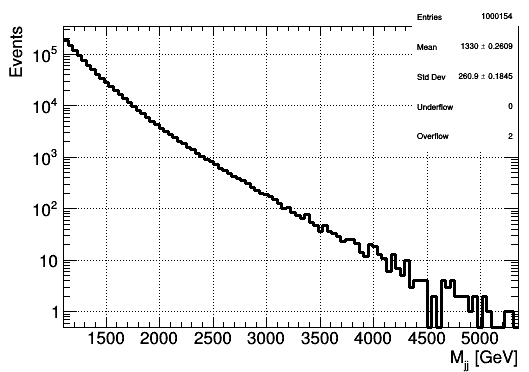

In [4]:
c = create_Canvas(size=(int(800/1.5),int(600/1.5)))
h_Mjj_side = create_TH1D(data_train[:,0], title='', axis_title = ['M_{jj} [GeV]','Events'], 
                binning=[100, Mjj_selection, 0.8*np.max(data_train[:,0])])

h_Mjj_side.Draw()
c.SetLogy()
c.Draw()


### Quantile regression 

In [5]:
def quantile_loss(target, pred):
    alpha = 1 - SM_eff
    err = target - pred
    return K.tf.where(err>=0, alpha*err, (alpha-1)*err)

inputs = Input(shape=(1,))
hidden = Dense(100, activation='relu')(inputs)
hidden = Dense(100, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
output = Dense(1)(hidden)
model = Model(inputs, output)
model.compile(loss=quantile_loss, optimizer=Adam(lr=1e-4))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 20,501
Trainable params: 20,501
Non-trainable params: 0
_________________________________________________________________


In [6]:
x_train = np.reshape(data_train[:,0], (-1,1))
y_train = computeDiscriminatingVar(data_train)
print(x_train.shape)
print(y_train.shape)

(1000154, 1)
(1000154,)


In [7]:
model.fit(scaleDownMjj(x_train), y_train, epochs=100, batch_size=10000, 
          verbose=1, validation_split=0.2, shuffle=True,
          callbacks=[EarlyStopping(monitor='val_loss', 
                                   patience=10, verbose=1),
                    ReduceLROnPlateau(factor=0.2, patience=3, 
                                      verbose=1, min_lr=1e-8)])

date = datetime.date.today()
date_str = '{}{:02d}{:02d}'.format(date.year, date.month, date.day)
model.save_weights('../models/dnn_cut_trained_{}.h5'.format(date_str))

Train on 800123 samples, validate on 200031 samples
Epoch 1/100
800123/800123 [==============================] - 3s 3us/step - loss: 0.0021 - val_loss: 3.1049e-04
Epoch 2/100
800123/800123 [==============================] - 2s 3us/step - loss: 2.8382e-04 - val_loss: 2.5825e-04
Epoch 3/100
800123/800123 [==============================] - 2s 3us/step - loss: 2.3917e-04 - val_loss: 2.2451e-04
Epoch 4/100
800123/800123 [==============================] - 2s 3us/step - loss: 2.1783e-04 - val_loss: 2.1558e-04
Epoch 5/100
800123/800123 [==============================] - 2s 3us/step - loss: 2.1390e-04 - val_loss: 2.1410e-04

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.99999994948e-05.
Epoch 6/100
800123/800123 [==============================] - 2s 3us/step - loss: 2.1326e-04 - val_loss: 2.1394e-04
Epoch 7/100
800123/800123 [==============================] - 2s 3us/step - loss: 2.1320e-04 - val_loss: 2.1390e-04
Epoch 8/100
800123/800123 [==============================] - 2s 3us/st

2019-11-04 04:31:34.813491: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA


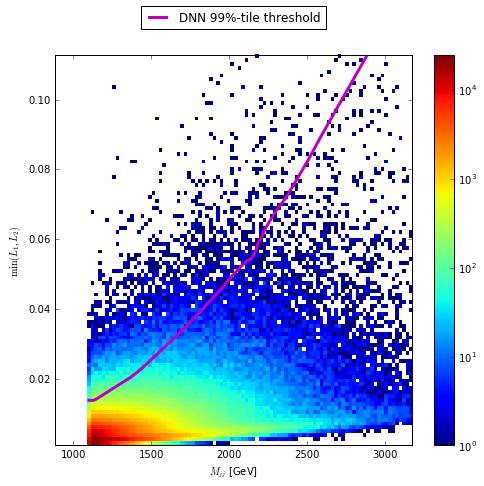

In [8]:
plt.figure(figsize=(8, 7))
x_min = Mjj_selection*0.8
x_max = np.percentile(x_train, 99.9)
x_train = x_train.reshape((-1,1))
plt.hist2d(x_train[:,0], y_train,
             range=((x_min , x_max), 
                    (np.min(y_train), np.percentile(y_train, 1e2*(1-1e-4)))), 
            norm=LogNorm(), bins=100,
            label='QCD signal region')

xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-Mjj_selection))
xs_ = scaleDownMjj(xs.reshape((-1,1)))
plt.plot(xs, model.predict(xs_), '-', 
         color='m', lw=3, label='DNN {:.0f}%-tile threshold'.format((1-SM_eff)*100))
plt.ylabel(yLossLabel())
plt.xlabel('$M_{jj}$ [GeV]')
plt.colorbar()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.14))
plt.draw()

In [9]:
def getSelection(x_Mjj, x_loss):
    # Do inference in batch 
    cut = model.predict(scaleDownMjj(np.reshape(x_Mjj, (-1,1))), batch_size=10000)
    sel = x_loss > cut.flatten()
    return sel

def plotMassSpectrum(mJJ_pass, mJJ_rej, title=''):
    h_a = create_TH1D(mJJ_pass, 
                      name='h_acc', title='Accepted',
                      binning=binning,
                      #opt='overflow'
                     )
    h_a.SetLineColor(2)
    h_a.SetStats(0)
    h_a.Sumw2()
    h_r = create_TH1D(mJJ_rej, 
                      name='h_rej', title='Rejected',
                      axis_title=['M_{jj} [GeV]', 'Events'],
                      binning=binning,
                      #opt='overflow'
                     )
    h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
    h_r.SetStats(0)
    h_r.Sumw2()

    c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-4, 0.2], draw_opt = 'E', title=title)
    c.pad1.SetLogy()
    c.pad2.SetLogy()

    c.pad2.cd()
    c.ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    c.ln.SetLineWidth(2)
    c.ln.SetLineStyle(7)
    c.ln.SetLineColor(8)
    c.ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)

    c.Draw()
    return c


# Define and test Goodness of fit test

In [10]:
def generateToysMC(nToys, seed):
    cmd = 'combine -M GoodnessOfFit --algo saturated \
           --fixedSignalStrength 0 -d datacard.txt -t {nToys} \
           --toysFreq -s {seed}'
    FNULL = open(os.devnull, 'w')
    subprocess.call(cmd.format(nToys=nToys, seed=seed), shell=True,
                   stdout=FNULL, stderr=subprocess.STDOUT)
    
def GoodnessOfFitTest(h_a, h_r, eff, 
                      nToys = 10000, maxToys = 1e7, 
                      show_hist=False, n_processes=20, max_processes=100):
    background_hist = h_r.Clone()
    background_hist.SetName("background")
    signal_hist = h_a.Clone() # not used
    signal_hist.Scale(0.005)
    signal_hist.SetName("signal")
    data_hist = h_a.Clone()
    data_hist.SetName("data_obs")

    data_hist.Sumw2()
    signal_hist.Sumw2()
    background_hist.Sumw2()
    #epsilon = eff/(1.-eff)
    epsilon = data_hist.Integral()/float(background_hist.Integral())
    background_hist.Scale(epsilon)
    
    # datacard template
    # no background normalization uncertainty
    # autoMCStats uncertainty
    datacard = \
    '''
    imax 1
    jmax 1
    kmax *
    ---------------
    shapes * * datacard_hist.root $PROCESS $PROCESS_$SYSTEMATIC
    ---------------
    bin acc
    observation {OBS}
    ------------------------------
    bin             acc     acc
    process         signal     background
    process         0          1
    rate            {SIGRATE}    {BKGRATE}
    --------------------------------
    #bgnorm   lnN    1.00       1.30
    * autoMCStats 0 0 1
    '''

    # write histograms to root file 
    datacard_hist = rt.TFile.Open('datacard_hist.root','recreate')
    datacard_hist.cd()
    background_hist.Write()
    signal_hist.Write()
    data_hist.Write()
    datacard_hist.Close()

    # write datacard
    datacard_real = datacard.format(SIGRATE=signal_hist.Integral(), 
                                    BKGRATE=background_hist.Integral(), 
                                    OBS=data_hist.Integral())
    with open('datacard.txt','w') as f:
        f.write(datacard_real)
        
    # Get observed test statistics
    cmd = 'combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard.txt'
    FNULL = open(os.devnull, 'w')
    subprocess.call(cmd, shell=True, stdout=FNULL, stderr=subprocess.STDOUT)
    obs_gof_file = uproot.open('higgsCombineTest.GoodnessOfFit.mH120.root')
    obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]
    print('Obs statistics = %.2f'%obs_gof)
    
    n_worse = 0
    n_total = 0
    loop = 0
    while n_worse < 25:
        loop += 1
        seed_loop = int(loop * 100000)
        # Get toys MC test statistics
        process = []
        for i in range(n_processes):
            p = Process(target=generateToysMC, 
                        args=(int(nToys/n_processes), (seed_loop+i+1)))
            p.start()
            time.sleep(0.5)
            process.append(p)
        for p in process:
            p.join()

        # Merge all files
        if os.path.exists("higgsCombineTest.GoodnessOfFit.mH120.{}.root".format(seed_loop)):
            os.remove("higgsCombineTest.GoodnessOfFit.mH120.{}.root".format(seed_loop))
            
        subprocess.call('hadd -k higgsCombineTest.GoodnessOfFit.mH120.{}.root \
        higgsCombineTest.GoodnessOfFit.mH120.{}00*.root'.format(seed_loop, loop), 
                        stdout=FNULL, 
                        stderr=subprocess.STDOUT, shell=True)
        for i in range(n_processes): # Remove the merged ones to avoid cluttering and confusion
            os.remove("higgsCombineTest.GoodnessOfFit.mH120.{}.root".format(seed_loop+i+1))

        # Merge with previous loop
        if os.path.exists("higgsCombineTest.ToyMCResult.root"):
            os.remove("higgsCombineTest.ToyMCResult.root")
        subprocess.call('hadd -k higgsCombineTest.ToyMCResult.root \
        higgsCombineTest.GoodnessOfFit.mH120.*0000.root', 
                        stdout=FNULL, 
                        stderr=subprocess.STDOUT, shell=True)
         
        exp_gof_file = uproot.open('higgsCombineTest.ToyMCResult.root')
        exp_gof = exp_gof_file['limit'].arrays('limit')['limit']

        # # get p-value
        n_extreme = len(exp_gof[exp_gof > obs_gof])
        n_total = len(exp_gof)
        n_worse = n_extreme
        print("Loop {}: Found {} toys MC > {}".format(loop, n_worse, obs_gof))
        if n_total > maxToys:
            print("Give up.")
            subprocess.call("rm higgsCombineTest.GoodnessOfFit.mH120.*0000.root", shell=True)
            return 
        if n_worse < 25:
            ratio = 25/max(n_worse,1)
            nToys *= ratio
            n_processes *= ratio
            n_processes = min(n_processes, max_processes)
            print("Retrying with {} toys MC and {} processes".format(nToys, n_processes))
        
    pval = 1.*float(n_worse)/n_total
    print ('p-value = {:.2E}'.format(Decimal(pval)))
    
    if show_hist:
        
        plt.figure(figsize=(8,6))
        binContent, _, _ = plt.hist(exp_gof,
                                    bins=50,
                                    label='Distribution assuming eff={:.1f}%'.format(100*eff))
        plt.plot([obs_gof, obs_gof], [0,np.max(binContent)], label='Observed')
        plt.legend(loc='best')
        plt.xlabel('Test statistic')
        plt.ylabel('Entries')
        plt.show()
        
    # Cleaning
    subprocess.call("rm higgsCombineTest.GoodnessOfFit.mH120.*0000.root", shell=True)
    return pval

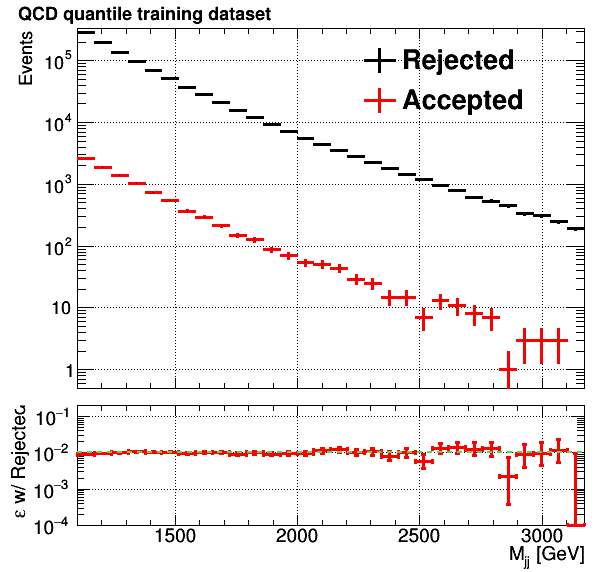

In [11]:
binning=[30, Mjj_selection, np.percentile(x_train, 99.9)]
sel_train = getSelection(x_train, y_train)

c = plotMassSpectrum(x_train.flatten()[sel_train], 
                     x_train.flatten()[np.logical_not(sel_train)], 
                     'QCD quantile training dataset')
h_a = c.h_list[1]
h_r = c.h_list[0]

# pval = GoodnessOfFitTest(h_a, h_r, SM_eff, 
#               nToys=1000, maxToys=1e6, 
#               show_hist=True, n_processes=20)


# Analyze Signal Region

In [12]:
base_dir = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/'

sample_loc = {'qcdSigExt': '/qcd_sqrtshatTeV_13TeV_PU40_EXT_ALL',  #_ALL # ext + ext2
              'GtoWW1': '/RSGraviton_WW_NARROW_13TeV_PU40_1.5TeV',
              'GtoWW2': '/RSGraviton_WW_NARROW_13TeV_PU40_2.5TeV',
              'GtoWW3': '/RSGraviton_WW_NARROW_13TeV_PU40_3.5TeV',
              #'GtoWW4': base_dir + '/RSGraviton_WW_NARROW_13TeV_PU40_4p5TeV',
              'AtoHZ': '/AtoHZ_to_ZZZ_13TeV_PU40',
              'GtoTTBroad': '/RSGraviton_tt_BROAD_13TeV_PU40',
              'GtoTTNarr': '/RSGraviton_tt_NARROW_13TeV_PU40'
             }

sample_label = {'qcdSigExt':r'QCD signal',
                'GtoWW1':r'$G(1.5 TeV)\to WW$',
                'GtoWW2':r'$G(2.5 TeV)\to WW$',
                'GtoWW3':r'$G(3.5 TeV)\to WW$',
                #'GtoWW4':r'$G(4.5 TeV)\to WW$',
                'AtoHZ':r'$A \to HZ \to ZZZ$',
                'GtoTTBroad':r'$G \to t \bar{t}$ broad',
                'GtoTTNarr':r'$G \to t \bar{t}$ narrow'
               }

sample_label_ROOT = {'qcdSigExt':'QCD signal',
                'GtoWW1':'G(1.5 TeV) to WW$',
                'GtoWW2':'$G(2.5 TeV) to WW$',
                'GtoWW3':'$G(3.5 TeV) to WW$',
                #'GtoWW4':'$G(4.5 TeV) to WW$',
                'AtoHZ':'A to HZ to ZZZ',
                'GtoTTBroad':'G to TT broad',
                'GtoTTNarr':'G to TT narrow'
               }

SM_samples = ['qcdSigExt']
BSM_samples = ['GtoWW1', 'GtoWW2', 'GtoWW3', 'GtoWW4','AtoHZ','GtoTTBroad', 'GtoTTNarr']

sample_nGenEvts = {'qcdSigExt': 6698*10000, 
                   'GtoWW1': 99*10000,
                   'GtoWW2': 92*10000,
                   'GtoWW3': 92*10000,
                   'GtoWW4': 97*10000,
                   'AtoHZ': 98*1000,
                   'GtoTTBroad': 98*1000,
                   'GtoTTNarr': 96*1000
                  }

sample_color = {'qcdSigExt': 'k', 
                   'GtoWW1': 'm',
                   'GtoWW2': 'g',
                   'GtoWW3': 'r',
                   'AtoHZ': 'b',
                   'GtoTTBroad': 'c',
                   'GtoTTNarr': 'brown',
                  }

sample_xsec = {'qcdSigExt': 8734.0 #pb
              }

lumi_generated = sample_nGenEvts['qcdSigExt']/sample_xsec['qcdSigExt']
print('Lumi: {:.1f} pb^-1'.format(lumi_generated))

Lumi: 7668.9 pb^-1


## Get the data

In [13]:
data = {}
sample_eff = {}
vae_eff = {}
table = PrettyTable()
table.field_names = ['Sample', 'Trg evts', 'Eff. trg [%]', 'VAE sel. evts', 'Eff VAE [%]']

for n, name_tag in sample_loc.iteritems():

    lookup = base_dir + name_tag + '/' + '*result.h5'
    flist = glob(lookup)
    if len(flist)==0:
        print("Couldn't find any files for {}. Skipping.".format(lookup))
        continue
    print("{} has {} files".format(n, len(flist)))
    x = None
    pb = ProgressBar(len(flist))
    for i, fname in enumerate(flist):
        pb.show(i)
        f = h5py.File(fname, 'r')
        aux_evts = np.array(f.get('results'))
        aux_evts = aux_evts[aux_evts[:,0] > Mjj_selection]
        if x is None:
            x = aux_evts
        else:
            x = np.append(x, aux_evts, axis=0)

    # apply the dijet mass cut
    dVar = computeDiscriminatingVar(x)
    sel = getSelection(x[:,0], dVar)
    x = np.column_stack((x, dVar, sel))
    print(x.shape[0])
    sample_eff[n] = float(x.shape[0])/sample_nGenEvts[n]

    dt = [(str(s), '<f4') for s in list(f.get("labels")) + ['dVar']]
    dt += [('sel', '?')]
    data[n] = np.array(list(zip(*x.T)), dtype=dt)
    vae_eff[n] = np.sum(data[n]['sel'])/float(data[n]['sel'].shape[0])
    eff = '{:.2f}'.format(100*vae_eff[n])
    table.add_row([n, data[n]['sel'].shape[0], '{:.1f}'.format(100*sample_eff[n]), np.sum(data[n]['sel']), eff])
    
print(table)

qcdSigExt has 6698 files
[####################]  100% - Tot. time: 829.8 s
2075736
GtoTTNarr has 96 files
[####################]  100% - Tot. time: 5.1 s
63572
GtoWW1 has 99 files
[####################]  100% - Tot. time: 7.6 s
371292
GtoTTBroad has 98 files
[####################]  100% - Tot. time: 4.9 s
64822
AtoHZ has 98 files
[####################]  100% - Tot. time: 5.9 s
63128
GtoWW2 has 92 files
[####################]  100% - Tot. time: 8.7 s
474653
GtoWW3 has 92 files
[####################]  100% - Tot. time: 8.3 s
518954
+------------+----------+--------------+---------------+-------------+
|   Sample   | Trg evts | Eff. trg [%] | VAE sel. evts | Eff VAE [%] |
+------------+----------+--------------+---------------+-------------+
| qcdSigExt  | 2075736  |     3.1      |     19867     |     0.96    |
| GtoTTNarr  |  63572   |     66.2     |      6773     |    10.65    |
|   GtoWW1   |  371292  |     37.5     |     26362     |     7.10    |
| GtoTTBroad |  64822   |     66.1    

### Visualize the BSM

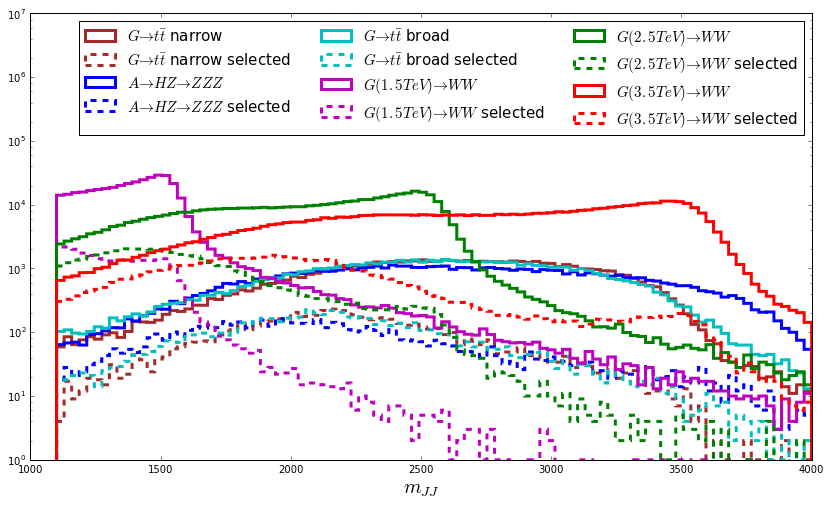

In [14]:

plt.figure(figsize=(14,8))
for n, indata in data.iteritems():
    if 'qcd' in n: continue
    binContents, _, _ = plt.hist(data[n]['mJJ'].flatten(), 
                                 bins=100, range=(1100,4000),
                                 label=sample_label[n], histtype='step',
                                 linewidth=3, color=sample_color[n])
    binContents, _, _ = plt.hist(data[n]['mJJ'][data[n]['sel'].astype(np.bool)].flatten(), 
                             bins=100, range=(1100,4000), linewidth=3,
                             label=sample_label[n]+' selected', histtype='step',
                             alpha=1, color=sample_color[n], linestyle='dashed')
plt.legend(loc='best', fontsize=15, ncol=3)
plt.xlabel('$m_{JJ}$', fontsize=20)
plt.yscale('log')
plt.ylim(0, 1e7)
plt.show()
    

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/1.5.2-gnimlf2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


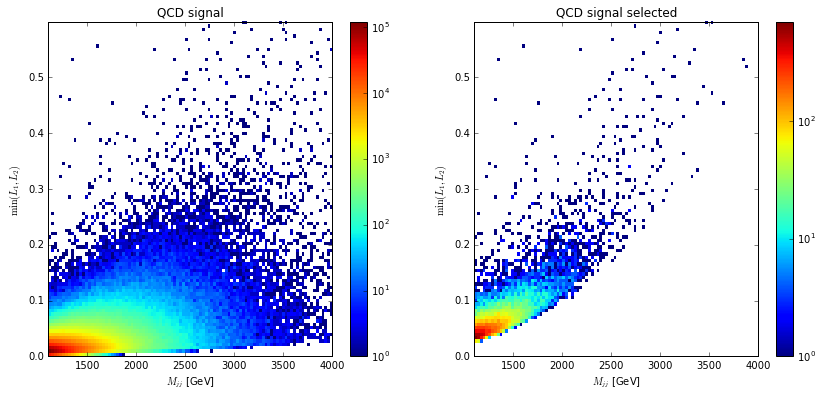

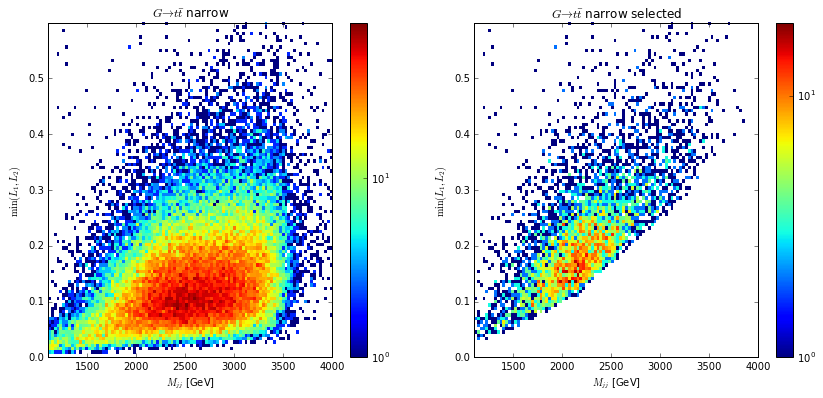

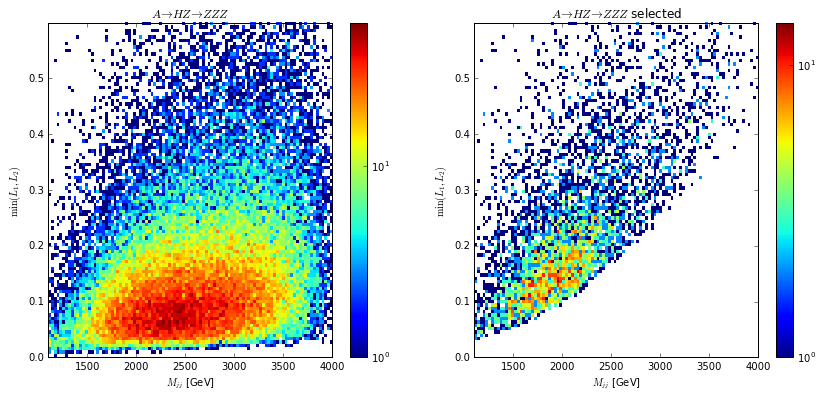

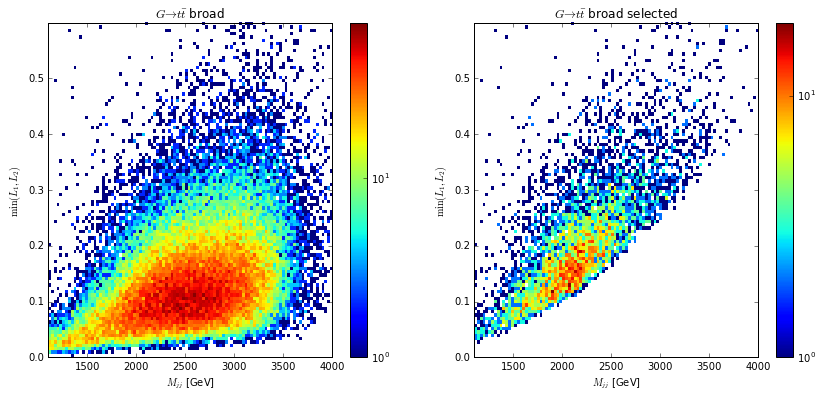

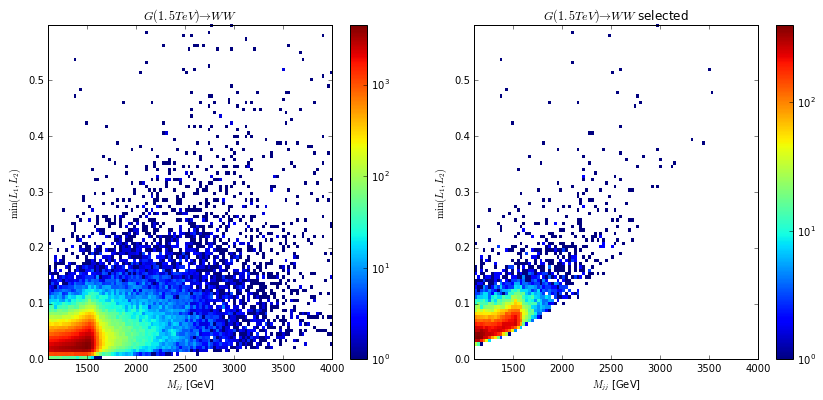

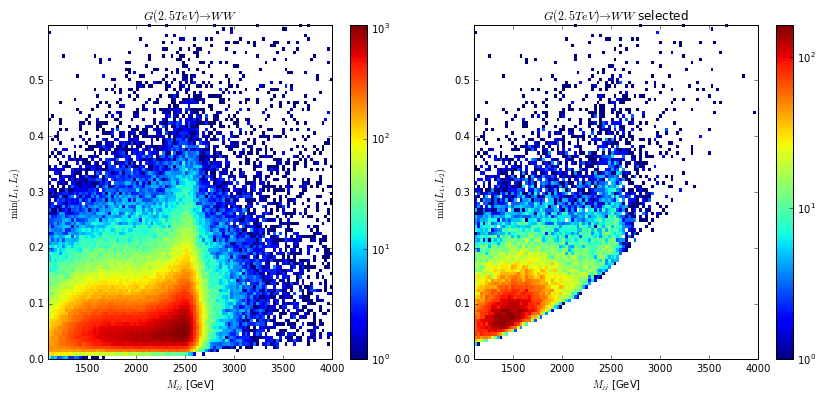

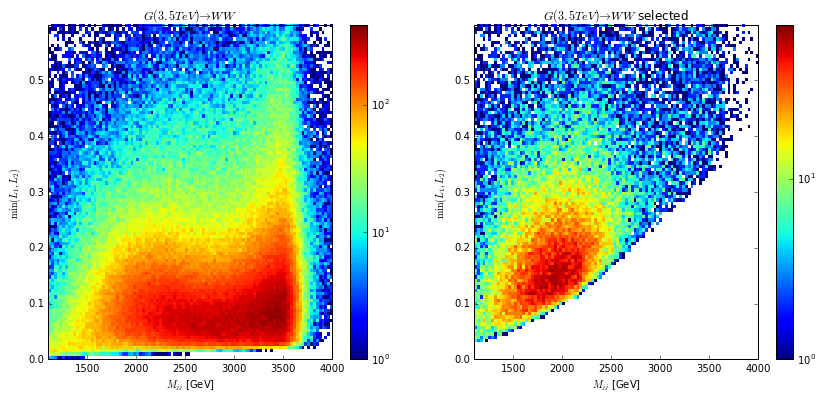

In [15]:
for n in data:
    #if 'qcd' in n: continue
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.hist2d(data[n]['mJJ'].flatten(), (data[n]['j1TotalLoss']+data[n]['j2TotalLoss']).flatten(),
             bins=100, range=((1100,4000),(0,0.6)),
             label=sample_label[n], 
             norm=LogNorm())
    plt.ylabel(yLossLabel())
    plt.xlabel('$M_{jj}$ [GeV]')
    plt.colorbar()
    plt.title(sample_label[n])
    plt.legend(loc='best')
    
    plt.subplot(1,2,2)
    total_loss = data[n]['j1TotalLoss']+data[n]['j2TotalLoss']
    sel_idx = data[n]['sel'].astype(np.bool)
    plt.hist2d(data[n]['mJJ'][sel_idx].flatten(), 
               total_loss[sel_idx].flatten(),
             bins=100, range=((1100,4000),(0,0.6)),
             label=sample_label[n]+' selected', 
             norm=LogNorm())
    plt.ylabel(yLossLabel())
    plt.xlabel('$M_{jj}$ [GeV]')
    plt.colorbar()
    plt.legend(loc='best')
    plt.title(sample_label[n]+" selected")
    plt.show()

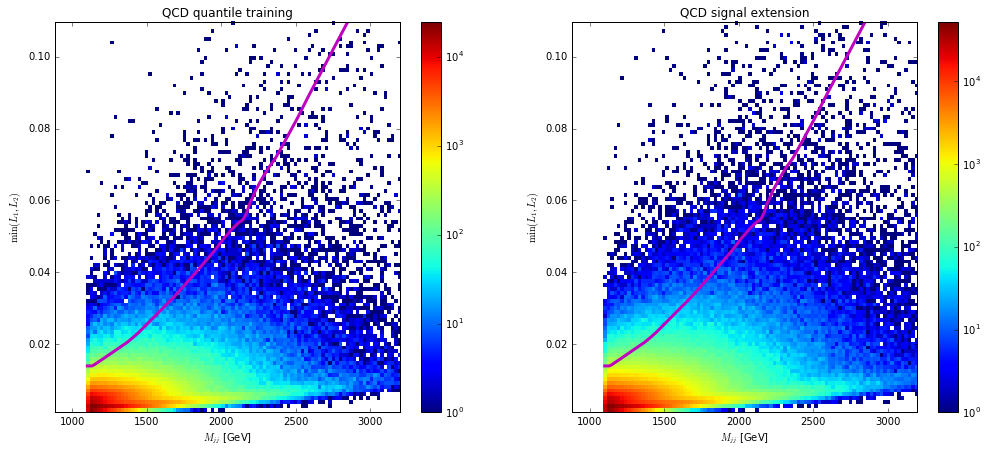

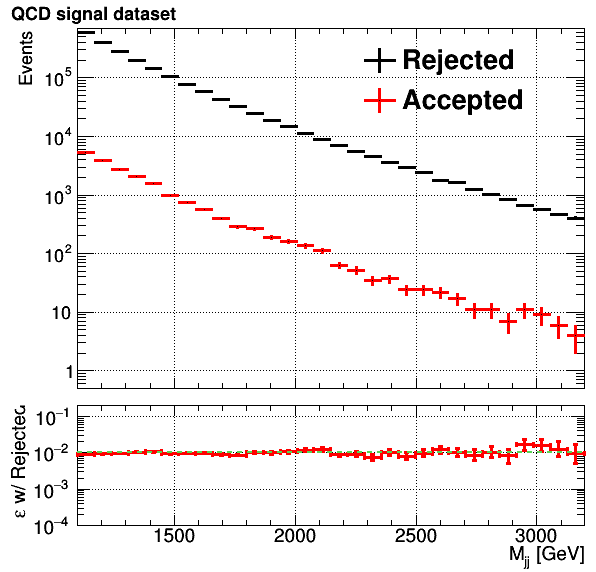

In [16]:
x = np.reshape(data['qcdSigExt']['mJJ'], (-1,1))
y = computeDiscriminatingVar_str(data['qcdSigExt']['j1TotalLoss'], data['qcdSigExt']['j2TotalLoss'])

plt.figure(figsize=(17, 7))
x_min = Mjj_selection*0.8
x_max = np.percentile(x, 99.9)
x_train = x_train.reshape((-1,1))
y_min = np.min(y)
y_max = np.percentile(y, 1e2*(1-1e-4))
plt.subplot(1,2,1)
plt.hist2d(x_train[:,0], y_train,
             range=((x_min , x_max), 
                    (y_min, y_max)), 
            norm=LogNorm(), bins=100,
            label='QCD signal region')
plt.title("QCD quantile training")
xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-Mjj_selection))
xs_ = scaleDownMjj(xs.reshape((-1,1)))
plt.plot(xs, model.predict(xs_), '-', 
         color='m', lw=3, label='DNN {:.0f}%-tile threshold'.format((1-SM_eff)*100))
plt.ylabel(yLossLabel())
plt.xlabel('$M_{jj}$ [GeV]')
plt.colorbar()
plt.draw()

plt.subplot(1,2,2)
plt.hist2d(x[:,0], y,
           range=((x_min , x_max), 
                  (y_min, y_max)), 
           norm=LogNorm(), bins=100,
           label='QCD Signal'
          )
plt.title("QCD signal extension")
xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-Mjj_selection))
plt.plot(xs, model.predict(scaleDownMjj(np.reshape(xs, (-1,1)))), '-', 
         color='m', lw=3, label='DNN {:.0f}%-tile threshold'.format((1-SM_eff)*100))
plt.ylabel(yLossLabel())
plt.xlabel('$M_{jj}$ [GeV]')
plt.colorbar()
plt.show()

binning=[30, Mjj_selection, np.percentile(x, 99.9)]

sel = getSelection(x, y)
c = plotMassSpectrum(x.flatten()[sel], x.flatten()[np.logical_not(sel)], 'QCD signal dataset')
h_a = c.h_list[1]
h_r = c.h_list[0]

# pval = GoodnessOfFitTest(h_a, h_r, SM_eff, 
#               nToys=1000, maxToys=1e6, 
#               show_hist=True, n_processes=20)

### Comparison between quantile training QCD and signal extension QCD

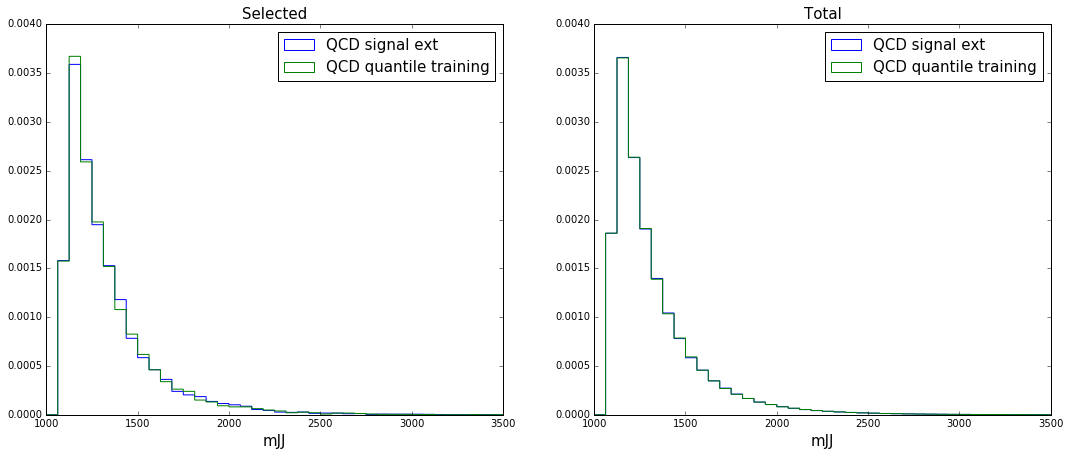

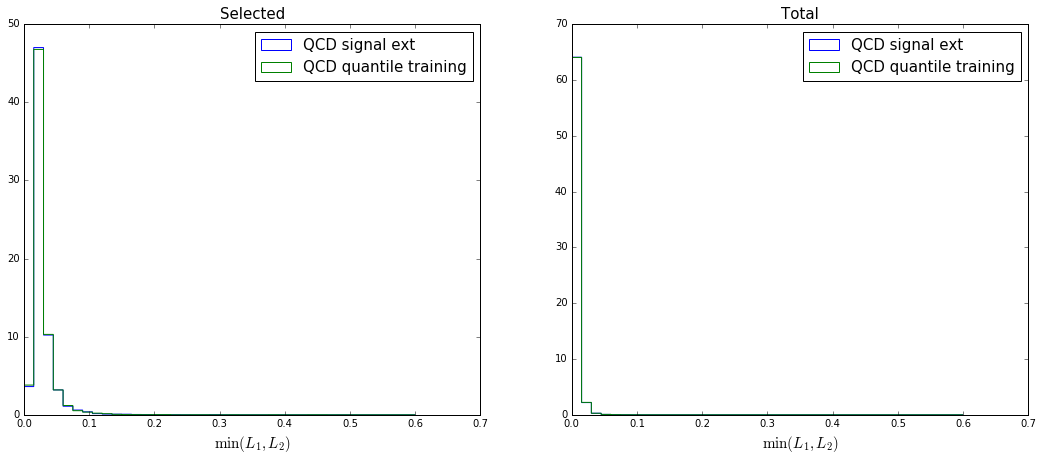

In [17]:
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.hist(x.flatten()[sel],label='QCD signal ext', 
         bins=40, range=(1000,3500), histtype='step', normed=True)
plt.hist(x_train.flatten()[sel_train],
         label='QCD quantile training', bins=40, 
         range=(1000,3500), histtype='step', normed=True)
plt.legend(loc='best', fontsize=15)
plt.xlabel('mJJ', fontsize=15)
plt.title("Selected", fontsize=15)
plt.subplot(1,2,2)
plt.hist(x.flatten(),label='QCD signal ext', 
         bins=40, range=(1000,3500), histtype='step', normed=True)
plt.hist(x_train.flatten(),label='QCD quantile training', 
         bins=40, range=(1000,3500), histtype='step', normed=True)
plt.legend(loc='best', fontsize=15)
plt.xlabel('mJJ', fontsize=15)
plt.title("Total", fontsize=15)
plt.show()

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.hist(y[sel],label='QCD signal ext', bins=40, 
         range=(0,0.6), histtype='step', normed=True)
plt.hist(y_train[sel_train],label='QCD quantile training', 
         bins=40, range=(0, 0.6), histtype='step', normed=True)
plt.xlabel(yLossLabel(), fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.title("Selected", fontsize=15)
plt.subplot(1,2,2)
plt.hist(y,label='QCD signal ext', bins=40, range=(0, 0.6), 
         histtype='step', normed=True)
plt.hist(y_train,label='QCD quantile training', bins=40, 
         range=(0,0.6), histtype='step', normed=True)
plt.xlabel(yLossLabel(), fontsize=15)
plt.title("Total", fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.show()

# Goodness of Fit test for Combine

If we use a small lumi (like 2 fb$^{-1}$), the p-value without signal injection is OK. Things only get worse when lumi is higher (> 5 fb$^{-1}$).

In [18]:
lumi = 2000 #pb^-1
nToys = 5000
N_exp_per_xsec = 10
dic_p_val = {}
rt.gROOT.SetBatch(True)

xsec BSM = 1.00E-4
Experiment 0
Expecting 541340 qcdSigExt events
Expecting 0 GtoWW3 events
Obs statistics = 50.03
Loop 1: Found 96 toys MC > 50.0321670247
p-value = 1.92E-2


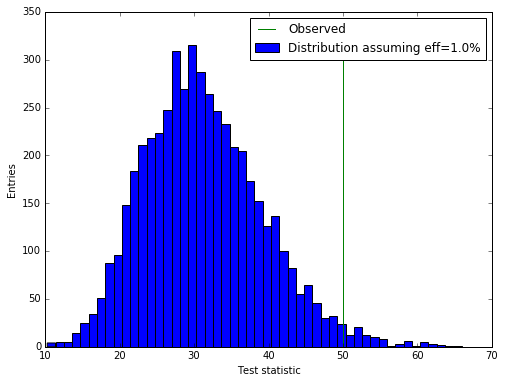

Experiment 1
Expecting 541340 qcdSigExt events
Expecting 0 GtoWW3 events
Obs statistics = 75.44
Loop 1: Found 0 toys MC > 75.4388344466
Retrying with 125000 toys MC and 100 processes
Loop 2: Found 0 toys MC > 75.4388344466
Retrying with 3125000 toys MC and 100 processes


In [ ]:
name_BSM = 'GtoWW3'
dic_p_val[name_BSM] = []
for xsec_BSM in np.logspace(-4, 2, 10):
    p_val_test = []
    print("xsec BSM = {:.2E}".format(Decimal(xsec_BSM)))
    for i_exp in range(N_exp_per_xsec):
        print("Experiment {}".format(i_exp))
        d_obs = np.zeros((0,2))
        sample_xsec[name_BSM] = xsec_BSM
        for n in SM_samples + [name_BSM]:
            nExpEvts = lumi*sample_xsec[n]*sample_eff[n]
            nEvts = int(nExpEvts)
            #nEvts = np.random.poisson(nExpEvts)
            print("Expecting {} {} events".format(nEvts, n))
            if data[n]['mJJ'].shape[0] < nEvts:
                print('[WARNING] ' + n + ' re-use factor = {:.2f}'.format(float(nEvts)/data[n]['mJJ'].shape[0]))
            evtsIdx = np.random.randint(0, data[n]['mJJ'].shape[0], size=(nEvts,))

            d_aux = np.column_stack((data[n]['mJJ'][evtsIdx], data[n]['sel'][evtsIdx]))
            d_obs = np.concatenate((d_obs, d_aux))

        h_a = create_TH1D(d_obs[:, 0][d_obs[:,1].astype(np.bool)], 
                             name='h_acc', title='Accepted',
                             binning=binning,
                             opt='overflow'
                            )

        h_r = create_TH1D(d_obs[:, 0][np.logical_not(d_obs[:,1]).astype(np.bool)], 
                             name='h_rej', title='Rejected',
                             axis_title=['M_{jj} [GeV]', ''],
                             binning=binning,
                             opt='overflow'
                            )
        pval = GoodnessOfFitTest(h_a, h_r, SM_eff, 
                                  nToys=nToys, maxToys=1e6, 
                                  show_hist=True, n_processes=20,
                                  max_processes=100)
        p_val_test.append(pval)
        
        if i_exp > 3 and np.max(p_val_test) == 0:
            break
        
    aux = [xsec_BSM] + list(np.percentile(p_val_test, [2.5, 16, 50, 84, 97.5]))
    dic_p_val[name_BSM].append(aux)
                

In [ ]:
sample_col = {
              'GtoWW1':'b',
              'GtoWW3':'g',
             }

matplotlib.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(8,8))

for n, val_aux in dic_p_val.iteritems():
    val_aux = np.array(val_aux)
    x_sec = val_aux[:, 0]
    quant = val_aux[:, 1:]
    
    ax1.plot(x_sec, quant[:, 2], color=sample_col[n], label=sample_label[n])
    print(x_sec, quant[:,2])
    ax1.fill_between(x_sec, quant[:, 1], quant[:, 3], color=sample_col[n], alpha = 0.1, lw=0)
#     ax1.fill_between(x_sec, quant[:, 0], quant[:, 4], color=sample_col[n], alpha = 0.1, lw=0)
    
    
plt.xscale('log')
plt.xlabel('Cross section [pb]')
plt.yscale('log')
plt.ylabel('p-value')
plt.ylim(1 - erf(5.5/np.sqrt(2)), 1)
plt.legend(loc='upper right')
ax2 = ax1.twinx()
for i in range(1, 6):
    p = 1 - erf(i/np.sqrt(2))
    ax2.plot([x_sec[0], x_sec[-1]], 2*[p], '--', color='grey')
plt.yscale('log')
ax2.set_yticks(1 - erf(np.arange(1,6)/np.sqrt(2)))
ax2.set_yticklabels(['{}$\sigma$'.format(i) for i in range(1,6)])
ax2.tick_params(axis='y', labelcolor='grey')
